In [1]:
# Pull data command:
# python download_data.py --project=discrete-mbrl-minigrid-trans-best --history_vars n_step goal_state_distrib_kl_div goal_delayed_state_distrib_kl_div goal_uniform_distrib_kl_div explore_right_state_distrib_kl_div explore_right_uniform_distrib_kl_div explore_right_delayed_state_distrib_kl_div --params codebook_size filter_size eval_policy env_name ae_model_type latent_dim trans_hidden e2e_loss

In [ ]:
import os
import sys
sys.path.append(os.path.abspath('../../..'))
from plotting_utils import *

import io
import pickle

from comet_ml.api import API
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

%matplotlib inline
set_matplotlib_style()

In [3]:
project_name = 'discrete-mbrl-minigrid-trans-best'

In [4]:
data_path = f'data/{project_name}_data.csv'
df = pd.read_csv(data_path, index_col=0)
df['Model Type'] = df['ae_model_type']
# Drop nan model types
df = df.dropna(subset=['Model Type'])

model_type_map = {
  'ae': 'Vanilla AE',
  'vqvae': 'VQ-VAE',
  'fta_ae': 'FTA AE'
}
df['Model Type'] = df['Model Type'].apply(lambda x: model_type_map[x])
df['Model Type'] = df.apply(
  (lambda x: 'End-to-End' if x['e2e_loss'] == True else x['Model Type']),
  axis=1)

df.head()

/tmp/ipykernel_23340/111350174.py:2: DtypeWarning: Columns (7,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, index_col=0)


,step,n_step,ae_model_type,codebook_size,env_name,filter_size,latent_dim,trans_hidden,experiment_key,explore_right_state_distrib_kl_div,explore_right_uniform_distrib_kl_div,goal_state_distrib_kl_div,goal_uniform_distrib_kl_div,goal_delayed_state_distrib_kl_div,explore_right_delayed_state_distrib_kl_div,e2e_loss,Model Type
0,0,0,ae,None,minigrid-crossing-stochastic,8,1024,1024,1b2f4393ca56439e8a3b8786d8d509c6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Vanilla AE
1,1,1,ae,None,minigrid-crossing-stochastic,8,1024,1024,1b2f4393ca56439e8a3b8786d8d509c6,0.011562,4.125888,NaN,NaN,NaN,NaN,NaN,Vanilla AE
2,2,2,ae,None,minigrid-crossing-stochastic,8,1024,1024,1b2f4393ca56439e8a3b8786d8d509c6,0.160610,3.252357,NaN,NaN,NaN,NaN,NaN,Vanilla AE
3,3,3,ae,None,minigrid-crossing-stochastic,8,1024,1024,1b2f4393ca56439e8a3b8786d8d509c6,0.182361,2.838870,NaN,NaN,NaN,NaN,NaN,Vanilla AE
4,4,4,ae,None,minigrid-crossing-stochastic,8,1024,1024,1b2f4393ca56439e8a3b8786d8d509c6,0.287145,2.556366,NaN,NaN,NaN,NaN,NaN,Vanilla AE


In [5]:
kl_div_columns = [col for col in df.columns if 'kl_div' in col]
# Drop the rows where all of the columns are NaN
df = df.dropna(subset=kl_div_columns, how='all')

In [6]:
# Work out the policy types and simplify the KL divergence columns

def infer_policy_type(row):
  for key, val in row.items():
    if 'kl_div' in key and val is not None and not np.isnan(val):
      return key[:key.find('state')-1]
    

df['policy_type'] = df.apply(infer_policy_type, axis=1)
df['state_distrib_kl_div'] = df.apply(
  lambda row: row[row['policy_type'] + '_state_distrib_kl_div'],
  axis=1)
df['uniform_distrib_kl_div'] = df.apply(
  lambda row: row[row['policy_type'] + '_uniform_distrib_kl_div'],
  axis=1)
# df['delayed_state_distrib_kl_div'] = df.apply(
#   lambda row: row[row['policy_type'] + '_delayed_state_distrib_kl_div'],
#   axis=1)

df.drop(columns=kl_div_columns, inplace=True)
new_kl_div_columns = [col for col in df.columns if 'kl_div' in col]

In [7]:
df['latent_dim'] = df.apply(
  lambda row: f'({int(row["filter_size"]**2)} x {row["codebook_size"]})' \
  if row['ae_model_type'] == 'vqvae' else int(row['latent_dim']), axis=1)

In [8]:
# Get the mean values for the kl div columns over all 30 steps for each experiment

max_step = df['n_step'].max()
metadata_df = df[df['n_step'] == max_step]
metadata_df = metadata_df.drop(columns=new_kl_div_columns)

partial_df = df[df['n_step'] <= 30]
mean_df = partial_df[['experiment_key'] + new_kl_div_columns].groupby('experiment_key').mean()
mean_df = metadata_df.merge(mean_df, on='experiment_key')
mean_df = mean_df.drop(columns=['step', 'n_step'])

Plotted runs: 16
448


/tmp/ipykernel_23340/920015120.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_rows['state_distrib_kl_div'] = baseline_rows[f'{baseline_type}_distrib_kl_div']
/tmp/ipykernel_23340/920015120.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_rows['Model Type'] = f'{baseline_title}'


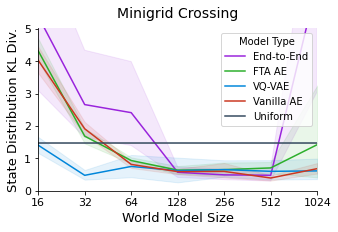

448


/tmp/ipykernel_23340/920015120.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_rows['state_distrib_kl_div'] = baseline_rows[f'{baseline_type}_distrib_kl_div']
/tmp/ipykernel_23340/920015120.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_rows['Model Type'] = f'{baseline_title}'


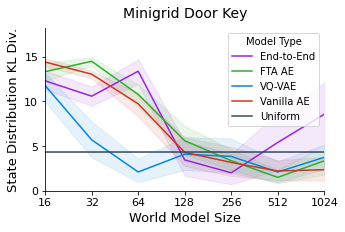

In [9]:
hidden_sizes = mean_df['trans_hidden'].unique()
hidden_sizes = sorted(hidden_sizes)

min_runs = 30
for keys, group in mean_df.groupby([
    'env_name', 'policy_type', 'trans_hidden', 'Model Type']):
  n_runs = len(group['experiment_key'].unique())
  min_runs = min(min_runs, n_runs)
print('Plotted runs:', min_runs)

for keys, group in mean_df.groupby(['env_name', 'policy_type']):
  # Count the number of runs (number of times n_step == 30) for each ae_model_type

  # Limit the number of runs to the minimum number of runs across for each trans_hidden and Model Type
  select_rows = []
  for subkeys, subgroups in group.groupby(['trans_hidden', 'Model Type']):
    select_runs = subgroups['experiment_key'].unique()[:min_runs]
    select_rows.append(subgroups[subgroups['experiment_key'].isin(select_runs)])
  group = pd.concat(select_rows)
  print(len(group['experiment_key'].unique()))

  baseline_row_sets = []
  for baseline_type in ['uniform']:
    baseline_rows = group[group['ae_model_type'] == 'ae']
    baseline_rows['state_distrib_kl_div'] = baseline_rows[f'{baseline_type}_distrib_kl_div']
    baseline_title = baseline_type.replace('_', ' ').title()
    baseline_rows['Model Type'] = f'{baseline_title}'
    baseline_row_sets.append(baseline_rows)

  for baseline_rows in baseline_row_sets:
    group = pd.concat([group, baseline_rows])

  # Reindex group
  group = group.reset_index(drop=True)

  color_palette = get_color_palette(group['Model Type'].unique())
  sns.lineplot(
    group, x='trans_hidden', y='state_distrib_kl_div', hue='Model Type',
    errorbar='ci', palette=color_palette, estimator=np.mean, err_kws={'alpha': 0.1})


  plt.title(standardize_env_name(keys[0]))
  set_fig_labels('World Model Size', 'State Distribution KL Div.')

  ax = plt.gca()
  plt.xscale('log', base=2)
  plt.xticks(hidden_sizes)
  ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

  plt.xlim(min(hidden_sizes), max(hidden_sizes))
  max_y = np.percentile(group['state_distrib_kl_div'], 96)
  max_y *= 1.2
  plt.ylim(0, max_y)

  save_fig_versions(f'{standardize_env_name(keys[0])}_trans_ablation')
  plt.show()


Plotted runs: 16
448


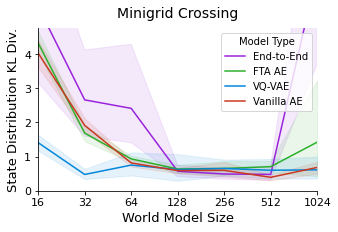

448


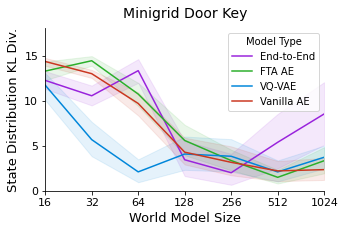

In [10]:
hidden_sizes = mean_df['trans_hidden'].unique()
hidden_sizes = sorted(hidden_sizes)

min_runs = 30
for keys, group in mean_df.groupby([
    'env_name', 'policy_type', 'trans_hidden', 'Model Type']):
  n_runs = len(group['experiment_key'].unique())
  min_runs = min(min_runs, n_runs)
print('Plotted runs:', min_runs)

for keys, group in mean_df.groupby(['env_name', 'policy_type']):
  # Limit the number of runs to the minimum number of runs across for each trans_hidden and Model Type
  select_rows = []
  for subkeys, subgroups in group.groupby(['trans_hidden', 'Model Type']):
    select_runs = subgroups['experiment_key'].unique()[:min_runs]
    select_rows.append(subgroups[subgroups['experiment_key'].isin(select_runs)])
  group = pd.concat(select_rows)
  print(len(group['experiment_key'].unique()))

  color_palette = get_color_palette(group['Model Type'].unique())
  sns.lineplot(
    group, x='trans_hidden', y='state_distrib_kl_div', hue='Model Type',
    errorbar='ci', palette=color_palette, estimator=np.mean, err_kws={'alpha': 0.1})
  

  plt.title(standardize_env_name(keys[0]))
  set_fig_labels('World Model Size', 'State Distribution KL Div.')

  ax = plt.gca()
  plt.xscale('log', base=2)
  plt.xticks(hidden_sizes)
  ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

  plt.xlim(min(hidden_sizes), max(hidden_sizes))

  max_y = np.percentile(group['state_distrib_kl_div'], 93)
  max_y *= 1.2
  plt.ylim(0, max_y)


  save_fig_versions(f'{standardize_env_name(keys[0])}_trans_ablation_nb')
  plt.show()
